# Image classification using dataset from EBay
In this project, we classify the images into different categories of products using the dataset scraped from EBAY. This project is divided into two main parts,: one is  scraping the data and next is using that scraped data to train our model.

Link to our github : https://github.com/Suruchi-cmd/Image-Classification-using-Ebay

Consists of dataset,ipynb test dataset and also both the pretrained models.

# Setting Up Environment
*   Installing required python libraries( requests & selenium ) for web scraping.
*   Installing chromium driver for selenium

In [164]:
!pip install selenium
!pip install requests
!pip install chromium-driver


ERROR: Could not find a version that satisfies the requirement chromium-driver (from versions: none)
ERROR: No matching distribution found for chromium-driver


## Importing necessary libraries 
The necessary libraries we are importing from the model is as follows:

In [165]:
import os
import time
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from rembg import remove
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

## Web Scarping from EBAY

In the previous class, when we used selenium, the browser kept opening during the web scraping, which caused misinconvenience during the data scraping. This time we have enabled headless browsing in order to prevent that.

In [166]:
def web_driver():
  """
    Creates a webdriver instance for chrome browser with specified options.

    Returns:
          webdriver: An instance of webdriver for chrome browser with specified options.
  """
  options =  webdriver.ChromeOptions()
  options.add_argument("--verbose")
  options.add_argument("--no-sandbox")
  options.add_argument("--headless")
  options.add_argument("--disable-gpu")
  options.add_argument("--window-size=1920, 1200")
  options.add_argument("--disable-dev-shm-usage")
  driver =  webdriver.Chrome(options=options)
  return driver

This is a function to load the URL in the specified WebDriver instance.

In [167]:
def load_url(driver, url):
  """
    Loads a URL in the specified WebDriver instance.

    Args:
          driver (WebDriver): The webdriver to use for loading the url.
          url (str): The URL to load in the WebDriver instance.
  """

  driver.get(url)

This is a function used to search for any kind of query in the WebDriver in ebay.

In [168]:
def search_ebay(driver, query):
  """
    Searches for a query on eBay using the provided WebDriver instance.

    Args:
          driver (WebDriver): The WebDriver instance to use for performing the search.
          query (str): The query string to search for on eBay.
  """

  search_box =  driver.find_element("name","_nkw")
  search_box.clear()
  search_box.send_keys(query)
  search_box.submit()

We are using this function to download the specified image provided by the url.

In [169]:
def download_image(url, filename):
  """
    Downloads an image from the specified url and saves it with the provided filename.

    Args:
          url (str): The url of the image to download.
          filename (str): The filename to save the downloaded image with.
  """

  response = requests.get(url)
  if response.status_code == 200:
      with open(filename, 'wb') as f:
          f.write(response.content)
          print(f"Image downloaded as {filename}")
  else:
      print("Failed to download image")

This function searches for the image component until the timeout time, which is 10 seconds in default. Incase the website is taking time to load, we can increase the time by passing the timeout argument.

In [170]:
def find_element_until_timeout(driver, CSS_SELECTOR, timeout=10): # increase timeout if the ebay page takes time to load
  """
    Finds a web element identified by css selector until a timeout period is reached.

    Args:
          driver (WebDriver): The WebDriver instance to use for finding the element.
          CSS_SELECTOR (str): The css selector used to locate the element.
          timeout (int): The maximum time to wait for the element (default is 10 seconds).

    Raises:
          Exception: If the element is not found within the specified timeout period.
  """

  time = 0
  found =  False
  while not found:
    try:
      element = driver.find_elements(By.CSS_SELECTOR,CSS_SELECTOR)
      found =  True

    except:
      time.sleep(1)
      time+=1
      if time==timeout:
        raise Exception(f"Element {CSS_SELECTOR} Not found. Please check the CSS SELECTOR or try a different attribute.")


This is the function to get the imageurls we reuire for the data. We can make a decision on how many images we want to download in order to train our model.

In [171]:
def get_images_url(driver, min_number_of_images=5): #change the min_number_of_images to the number of images you require for every single category
  """
    Retrieves urls of images from ebay search results until a minimum number of images is reached.

    Args:
          driver (WebDriver): The WebDriver instance to use for navigating ebay search results.
          min_number_of_images (int): The minimum number of images to retrieve (default is 10).

    Returns:
          list: A list of image urls.
  """

  image_urls = []
  while not (len(image_urls)>=min_number_of_images):
    find_element_until_timeout(driver,"img[loading='eager']")
    images =  driver.find_elements(By.CSS_SELECTOR,"img[loading='eager']")
    for image in images:
      url = image.get_attribute("src")
      if ("i.ebayimg.com/thumbs" in url):
        image_urls.append(url)

    try: #Handling error when the min number of items exceed the number of items available on ebay
      find_element_until_timeout(driver,"a[class='pagination__next icon-link']")
      next_page = driver.find_element(By.CSS_SELECTOR,"a[class='pagination__next icon-link']")
      next_page.click()
    except:
      break


  return image_urls



In [172]:
def download_images(image_urls, folder_name):
  """
    Downloads images from a list of urls and saves them to the specified folder.

    This function downloads each image from the provided list of image urls and saves them to the specified folder
    with an incremental filename.

    Args:
        image_urls (list): A list of image urls to download.
        folder_name (str): The name of the folder where images will be saved.
  """
  filename = 0
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  for image_url in image_urls:
    download_image(image_url, f"{folder_name}/{filename}.png")
    filename+=1



We have chosen 4 classes to classify our image on:
- women's clothes
- men's clothes
- women's shoes
- men's shoes

We can add any number of classes we want, and our project will work for any custom dataset we would like to build.

In [173]:
ITEMS = ["girls apparel", "womens shoes", "boys apparel", "mens shoes"]  # Add more items to create image datasets for different categories

In [174]:
EBAY =  "https://www.ebay.com/"

In [175]:
MIN_IMAGES_PER_ITEM = 5 # change this number to download more images for each item

In [176]:
driver = web_driver()

In [177]:
load_url(driver, EBAY) 

We are scraping 150 items from each category

In [156]:
search_ebay(driver, "womens bags")

'<html lang="en" class=" history devicemotion deviceorientation"><!--<![endif]--><head><noscript class="x-page-config"></noscript><meta http-equiv="X-UA-Compatible" content="IE=edge"><script async="" src="https://ir.ebaystatic.com/rs/v/dxtuvtkk2q3hpkc1xveeo13iaek.js"></script><script>\n    (function () {\n        \'use strict\';\n        if (window.PerformanceObserver && performance && performance.mark && performance.getEntriesByName) {\n            window.SRP = window.SRP || {};\n            var paintObserver = new window.PerformanceObserver(function (list) {\n                var paintEntries = list.getEntries();\n                paintEntries.sort(function (a, b) {\n                    return a.startTime - b.startTime;\n                });\n                // begin looking for TTI at first contentful paint\n                if (!paintEntries || paintEntries.length < 2) {\n                    // to avoid undefined issue on Safari\n                    return;\n                }\n        

In [157]:
for item in ITEMS:
  search_ebay(driver, item)
  images =  driver.find_elements(By.CSS_SELECTOR,"img")
  img_urls = get_images_url(driver, MIN_IMAGES_PER_ITEM)
  folder_name = item.replace(" ","_")
  folder_name=os.path.join("dataset",folder_name)
  download_images(img_urls,folder_name)

Image downloaded as dataset\girls_apparel/0.png
Image downloaded as dataset\girls_apparel/1.png
Image downloaded as dataset\girls_apparel/2.png
Image downloaded as dataset\girls_apparel/3.png
Image downloaded as dataset\girls_apparel/4.png
Image downloaded as dataset\girls_apparel/5.png
Image downloaded as dataset\girls_apparel/6.png
Image downloaded as dataset\girls_apparel/7.png
Image downloaded as dataset\girls_apparel/8.png
Image downloaded as dataset\girls_apparel/9.png
Image downloaded as dataset\girls_apparel/10.png
Image downloaded as dataset\womens_shoes/0.png
Image downloaded as dataset\womens_shoes/1.png
Image downloaded as dataset\womens_shoes/2.png
Image downloaded as dataset\womens_shoes/3.png
Image downloaded as dataset\womens_shoes/4.png
Image downloaded as dataset\womens_shoes/5.png
Image downloaded as dataset\womens_shoes/6.png
Image downloaded as dataset\womens_shoes/7.png
Image downloaded as dataset\womens_shoes/8.png
Image downloaded as dataset\womens_shoes/9.png
I

In [ ]:
def delete_dataset(item_name):

  os.system(f'rm -r {item_name}')

['boys_apparel', 'girls_apparel', 'mens_shoes', 'womens_shoes']
boys_apparel


<Figure size 2500x500 with 0 Axes>

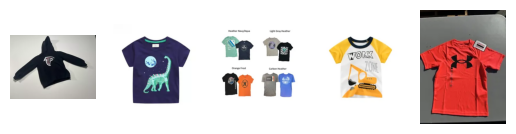

girls_apparel


<Figure size 2500x500 with 0 Axes>

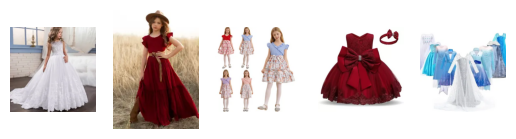

mens_shoes


<Figure size 2500x500 with 0 Axes>

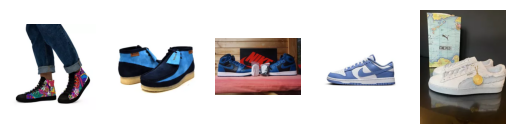

womens_shoes


<Figure size 2500x500 with 0 Axes>

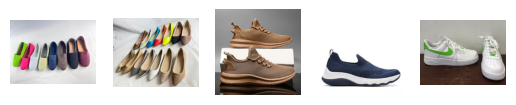

In [158]:
len_items = 5
def plot_images_by_category(main_folder,len_items = 5):
    """
    Plots images from each category subfolder within the main folder.

    Args:
    main_folder (str): The path to the main folder containing category subfolders.
    """
    # Get all category directories
    categories = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]
    print(categories)
    for category in categories:
        print(category)
        category_path = os.path.join(main_folder, category)        
        image_files = [f for f in os.listdir(category_path) if f.endswith(('.png'))]
        plt.figure(figsize=(25, 5))
        f, axarr = plt.subplots(1,len_items)
        for idx, file in enumerate(image_files[:len_items]):
            img_path = os.path.join(category_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB  
            axarr[idx].imshow(img)  
            axarr[idx].axis('off')  
            
        plt.show()

# main_folder_path = r'C:\Users\Admin\Downloads\ImageClassification-Tensorflow-main 1\ImageClassification-Tensorflow-main\imgDataSet'
main_folder_path="dataset"
plot_images_by_category(main_folder_path,len_items)


## Data Preprocessing

(300, 300, 3)

As we can see the image shapes, which are uneven, along with a lot of visuals in the background. The background in these images will be our noise, and it is necessary to remove any unnecessary noise from our images to improve the performance of our model. 

['boys_apparel', 'girls_apparel', 'mens_shoes', 'womens_shoes']
boys_apparel


<Figure size 2500x500 with 0 Axes>

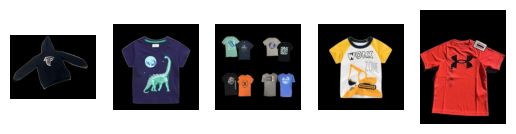

girls_apparel


<Figure size 2500x500 with 0 Axes>

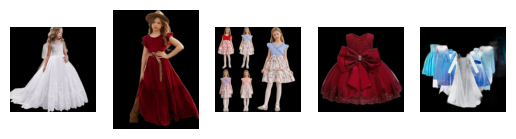

mens_shoes


<Figure size 2500x500 with 0 Axes>

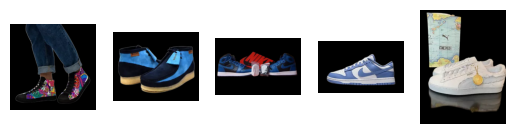

womens_shoes


<Figure size 2500x500 with 0 Axes>

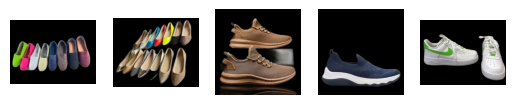

In [159]:
import numpy as np 
import time
def remove_background_with_rembg(image_path):
    """
    Removes the background from an image using the rembg library.
    Args:
    image_path (str): The file path to the input image.
    Returns:
    numpy.ndarray: The image with the background removed, returned as an OpenCV image.
    """
    input_image = open(image_path, 'rb').read()    
    output_image = remove(input_image)    
    output_image = cv2.imdecode(np.frombuffer(output_image, np.uint8), cv2.IMREAD_UNCHANGED)
    return output_image

main_folder = "dataset"
categories = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]
start_time = time.time()
for category in categories:
    category_path = os.path.join(main_folder, category)        
    image_files = [f for f in os.listdir(category_path) if f.endswith(('.png'))]    
    for idx, file in enumerate(image_files[:len_items]):
        img_path = os.path.join(category_path, file)
        background_removed_image = remove_background_with_rembg(img_path)
        cv2.imwrite(img_path,background_removed_image)
plot_images_by_category("dataset")
taken = time.time() -start_time
num_images = len(categories)*len(image_files)



In [94]:
print(f"Total time taken for {num_images} is {taken}" )

Total time taken for 44 is 305.38102626800537


As we can see that the images are more clear now. We have removed the background as a part of preprocessing step in the machine learning. We also know that the total time taken by the code to process the images is really high. For our machine learning model to function well, it is crucial that we have a high volume of data. Every category requires at least 1000 image data. We run into several encounters of getting an error from EBAY while trying to download such high volume of data.

In order to optimize our performance and accelerate our process, we have merged our scraped datset with the dataset already available from kaggle. 

# Deep Neural Networks 

Befor beginning the model training, it is necessary to understand the deep neural networks. The deep neural networks are nothing but artificial neural networks stacked hidden layers which can be multiple.
These layers are stacked on top of each other. Each layer has units that are connected to units in the previous layer through connections called weights. These weights determine how much influence each unit has on the next layer. There are various kinds of layers in the deep neural networks, such as convolution layer, dense layer, flatten , etc. 

Imagine you're looking at a picture of a woman. The first layer of the neural network might recognize basic shapes, like lines and curves in the image. As you move to the next layer, the units start to combine these shapes to recognize more complex features, such as part of a nose, eye,or teeth. By stacking more layers, the network can learn to recognize even more detailed aspects of the woman, like her eyes, mouth, nose.

## Using Keras and Tensorflow
We first begin by defining necessary parameters for model training and initialize a dataloader object of Tensorflow.

In [98]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
dataset_path = "imgDataSet"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2906 files belonging to 4 classes.


Batch_size = the number of images we specify in order to train the network in one epoch 

Image_size = the dimensions of image we want to load to the dataset by resizing. We usually keep this number low to save the computation time, but also high enough that the results are good

channels = number of channels in an image. This value is 3 for rgb image

epoch = number of cycles through the full dataset

In [99]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 2 0 1 0 1 2 3 1 0 2 1 3 3 1 1 1 0 0 3 0 3 1 0 3 0 2 2 1 2]


Image batch refers to one batch of images, As we have initialized, we can see that one batch consists of 32 images, each being 256X256 , 3 channels i.e. RBG channels. 

## Splitting the dataset
Here, we a splitting the data into train, test and validation set. The training size is 80% of the dataset. We take 54 batches from the main dataset for training. We skip those batches and take the rest of the batch for testing. From the test dataset, we take 6 batches for validation and other six for testing.

In [100]:
train_size = 0.8
train_ds = dataset.take(54)

test_ds = dataset.skip(54)

val_size = 0.1
val_ds = test_ds.take(6)

test_ds = test_ds.skip(6)

In [103]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """
    Splits a TensorFlow dataset into training, validation, and testing sets based on provided proportions.

    Args:
        ds (tf.data.Dataset): The dataset to split.
        train_split (float, optional): The fraction of the dataset to use for training. Default is 0.8.
        val_split (float, optional): The fraction of the dataset to use for validation. Default is 0.1.
        test_split (float, optional): The fraction of the dataset to use for testing. Default is 0.1.
        shuffle (bool, optional): Whether to shuffle the dataset before splitting. Default is True.
        shuffle_size (int, optional): Buffer size to use for shuffling the data. Default is 10000.

    Preconditions:
        - The sum of `train_split`, `val_split`, and `test_split` must be 1.

    Returns:
        tuple: A tuple containing three tf.data.Dataset objects:
            - train_ds: The training dataset.
            - val_ds: The validation dataset.
            - test_ds: The testing dataset.
    """
    assert (train_split + val_split + test_split) == 1

    ds_size = len(list(ds))  # This line should actually use ds.cardinality().numpy() if ds is a TensorFlow dataset.

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


We shuffle our datset in order to prevent bias, increase randomization and improve model generalization.

In [104]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Preprocessing with Tensorflow
There are various steps to preprocess the image data. The first one is normalizing. The image data by default consists of integers between 0 and 255 for each pixel channel. Neural networks usually perform best when each input is inside the range –1 to 1, so we need to divide by 255.


In [105]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1. / 255),
])

Data augmentation is a technique used in training machine learning modelsthat artificially increases the diversity of data available for training models without actually collecting any of the new data. This is done by applying random transformations to the training images, such as flipping, rotation, scaling and color inversion. 

In [107]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


## Building the model

In [108]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [109]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

The various layers in the network are:

conv2D = This is a two dimensional convolutional layer which applies a filter over the image to extract important features. 

max pooling = It only keeps the maximum value from each window and reduces the size of the image you need to analyze. 

flatten = It is used in final layer to flatten all the 2d images to 1d for output 

In [110]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

The neural networks uses loss functions to compare the predicted values vs. the actual values. The grater value of loss signifies the degrading performance of our model.

## Training the model

In [113]:
 model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=2,
    )

model.save("object_detection_v1.h5")

Epoch 1/2
72/72 [==============================] - 153s 2s/step - loss: 0.8484 - accuracy: 0.6567 - val_loss: 0.6685 - val_accuracy: 0.7014
Epoch 2/2
72/72 [==============================] - 179s 2s/step - loss: 0.6677 - accuracy: 0.7293 - val_loss: 0.5305 - val_accuracy: 0.8229


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


This starts the training of the deep learning nwtwork to predict the category of the images provided in our dataset.

## Evaluating the model 
Right now we have an idea of how the model performs on training data, but we have no idea about how it performs on the test set. 

In [116]:
model.evaluate(test_ds)

10/10 [==============================] - 13s 1s/step - loss: 0.5070 - accuracy: 0.7812


[0.5070484280586243, 0.78125]

There is 78% accuracy with only 2 epochs of the model. In order to increase the accuracy of the model, we may increase the number of epochs.

We also perform evaluation on some images that we download from google in order to test our model is performing. 

In [133]:
import sys
CATEGORIES = ["Boys_Apparel", "Girls_Apparel", "Mens_Footwear", "Womens_Footwear"]

These are the four categories the model detects the image for, as we have set up the model to input images with dimensions 256x256, we have to resize the object according to those dimensions.

In [160]:
def convert_input_image(path):
    image_array = cv2.imread(path)
    img_shape = cv2.resize(image_array, (256, 256))
    return img_shape.reshape(1, 256, 256, 3)

model = tf.keras.models.load_model("object_detection_v1.h5")

We load the model and make predictions on the image. We return the class whose prediction is greater than 1

In [130]:
def predict_image(image_name):
    prediction = model.predict([convert_input_image(image_name)]).round()
    print(prediction)
    if prediction[0][0]>=1:
        return CATEGORIES[0]
    if prediction[0][1]>=1:
        return CATEGORIES[1]
    if prediction[0][2]>=1:
        return CATEGORIES[2]
    if prediction[0][3]>=1:
        return CATEGORIES[3]

GOOGLE_IMAGES_DIR = 'google_images_for_external_testing'

files = os.listdir(GOOGLE_IMAGES_DIR)

googled_images = [file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]

for image in googled_images:
    print(image, "====> ", predict_image(GOOGLE_IMAGES_DIR + "/"+ image))


1/1 [==============================] - 0s 54ms/step
[[0. 0. 0. 0.]]
boysapparel.jpg ====>  None
1/1 [==============================] - 0s 120ms/step
[[0. 1. 0. 0.]]
girlsapparel.jpg ====>  Girls_Apparel
1/1 [==============================] - 0s 155ms/step
[[0. 0. 0. 1.]]
heels.png ====>  Womens_Footwear
1/1 [==============================] - 0s 90ms/step
[[1. 0. 0. 0.]]
mensshoes.jpg ====>  Boys_Apparel


1/1 [==============================] - 0s 71ms/step
[[0. 0. 0. 0.]]
1/1 [==============================] - 0s 131ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 461ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 221ms/step
[[1. 0. 0. 0.]]


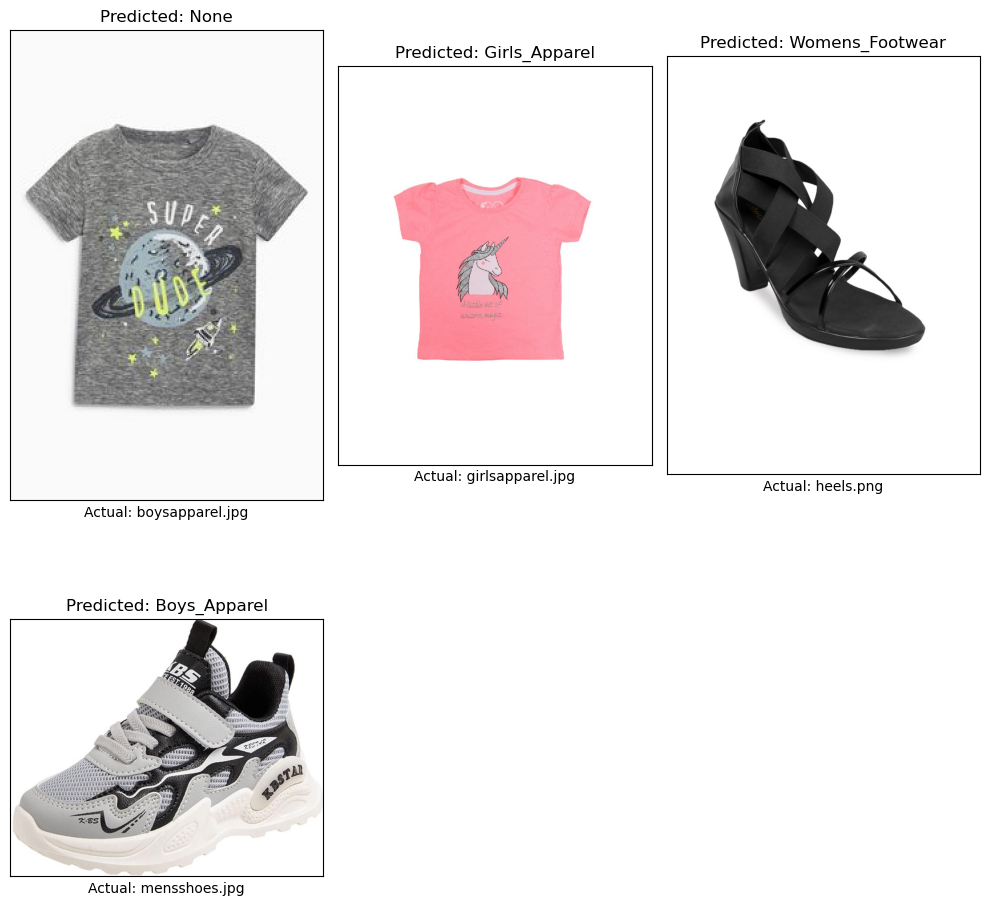

In [162]:
def display_predictions(directory):
    files = [f for f in os.listdir(directory) if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]
    
    num_files = len(files)
    cols = 3 
    rows = num_files // cols + (num_files % cols > 0)

    plt.figure(figsize=(10, 10))  
    for idx, file in enumerate(files):
        file_path = os.path.join(directory, file)
        prediction = predict_image(file_path)
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {prediction}")
        plt.xlabel(f"Actual: {file}")  
        plt.xticks([])  
        plt.yticks([])  
        
    plt.tight_layout()
    plt.show()
display_predictions(GOOGLE_IMAGES_DIR)


## Improving the model

In [140]:
from tensorflow.keras import models, layers

model2 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model2.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1,
        epochs=8,
    )

model2.save("object_detection_v2.h5")


Epoch 1/8
72/72 [==============================] - 136s 2s/step - loss: 1.7509 - accuracy: 0.4991 - val_loss: 1.3556 - val_accuracy: 0.3715
Epoch 2/8
72/72 [==============================] - 121s 2s/step - loss: 0.8073 - accuracy: 0.6610 - val_loss: 1.0796 - val_accuracy: 0.5590
Epoch 3/8
72/72 [==============================] - 135s 2s/step - loss: 0.7015 - accuracy: 0.6958 - val_loss: 1.2648 - val_accuracy: 0.5938
Epoch 4/8
72/72 [==============================] - 151s 2s/step - loss: 0.7000 - accuracy: 0.6867 - val_loss: 1.3560 - val_accuracy: 0.3576
Epoch 5/8
72/72 [==============================] - 127s 2s/step - loss: 0.6802 - accuracy: 0.7141 - val_loss: 1.0835 - val_accuracy: 0.5417
Epoch 6/8
72/72 [==============================] - 123s 2s/step - loss: 0.6387 - accuracy: 0.7263 - val_loss: 1.6611 - val_accuracy: 0.2674
Epoch 7/8
72/72 [==============================] - 124s 2s/step - loss: 0.6159 - accuracy: 0.7472 - val_loss: 2.3170 - val_accuracy: 0.2326
Epoch 8/8
72/72 [===

Our second model, despite being deeper than the first, tries to learn more than our first model. Since it is showing less accuracy on the training data, we do not have to check the testing data in order to determing its performance. 

In [163]:
model2.evaluate(test_ds)

10/10 [==============================] - 9s 754ms/step - loss: 0.5166 - accuracy: 0.7594


[0.5165907144546509, 0.7593749761581421]

In conclusion, our model1 performed better than model2.